# Introduction

In this notebook, we’ll explore how to train a lightweight NanoGPT on the Tiny Stories dataset. NanoGPT, developed by Andrej Karpathy, is a simplified variant of GPT designed for simplicity and speed. Our goal is to generate creative and coherent text based on the input data. I will also use Wandb library to track the experiments on the model.

# Import Libraries

In [1]:
# Clone the NanoGPT
!git clone https://github.com/karpathy/nanoGPT.git
!pip install tiktoken
!pip install wandb

Cloning into 'nanoGPT'...
remote: Enumerating objects: 686, done.
remote: Total 686 (delta 0), reused 0 (delta 0), pack-reused 686 (from 1)
Receiving objects: 100% (686/686), 954.04 KiB | 23.27 MiB/s, done.
Resolving deltas: 100% (387/387), done.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import nanoGPT.model as GPT
import wandb
import os

In [3]:
# Directly set your API key (not secure in public notebooks)
import wandb
wandb.login(key="2c31d7e5323a64ac198ab2499a802513a1ac5ec8")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raj-dandekar8 (raj-dandekar8-massachusetts-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
class GPTConfig: # Model config from NanoGPT
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

config = GPTConfig

In [5]:
wandb_config = {k:v for k,v in vars(config).items() if not callable(getattr(config, k)) and not k.startswith("__")} # Creating Wandb hyperparameters config for tracking experiements
wandb_config

{'block_size': 1024,
 'vocab_size': 50304,
 'n_layer': 12,
 'n_head': 12,
 'n_embd': 768,
 'dropout': 0.0,
 'bias': True}

In [6]:
wandb.init(project="nanogpt-tinystories", name="nanoGPT", config=wandb_config)


# Tiny Stories datasets and preprocessing

TinyStories, a synthetic dataset of short stories that only contain words that a typical 3 to 4-year-olds usually understand, generated by GPT-3.5 and GPT-4. We show that TinyStories can be used to train and evaluate LMs that are much smaller than the state-of-the-art models (below 10 million total parameters)

In [7]:
!pip install --upgrade datasets --quiet



from datasets import load_dataset

!rm -rf ~/.cache/huggingface/datasets
!rm -rf /root/.cache/huggingface/datasets
!rm -rf /content/.cache/huggingface/datasets

ds = load_dataset("roneneldan/TinyStories")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [8]:
import tiktoken
import os

enc = tiktoken.get_encoding("gpt2")

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

# Training

In [9]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [10]:
# Training Config

learning_rate = 1e-5
max_iters = 4000
warmup_steps = 100
min_lr = 1e-6
eval_iters = 500
batch_size = 20
block_size = 128

gradient_accumulation_steps = 20

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [11]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

nanoGPT = GPT.GPT(config)
optimizer =  torch.optim.AdamW(nanoGPT.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

number of parameters: 123.69M


/tmp/ipython-input-11-2917886634.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [12]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"

import os

checkpoint_path = "checkpoint.pt"
start_epoch = 0

# Resume if checkpoint exists
if os.path.exists(checkpoint_path):
    print("🔁 Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    nanoGPT.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    best_val_loss = checkpoint['best_val_loss']
    start_epoch = checkpoint['epoch'] + 1
    print(f"✅ Resumed from epoch {start_epoch}")

train_loss_list, validation_loss_list = [], []

for epoch in tqdm(range(start_epoch, max_iters)):
    if epoch%eval_iters == 0 and epoch != 0:
        losses = estimate_loss(nanoGPT)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        wandb.log({
                "epoch": epoch,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": optimizer.param_groups[0]['lr']
            })

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(nanoGPT.state_dict(), best_model_params_path)

        # Save full training state at every eval
        torch.save({
            'epoch': epoch,
            'model_state_dict': nanoGPT.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        print(f"💾 Saved checkpoint at epoch {epoch}")


    X,y = get_batch("train")

    with ctx:
        logits, loss = nanoGPT(X, y)
        loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(nanoGPT.parameters(), 1)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()


wandb.finish()

  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRE

Epoch 500: train loss 8.5755, val loss 8.5912
The current learning rate: 0.0000
💾 Saved checkpoint at epoch 500
Epoch 1000: train loss 7.7521, val loss 7.7442
The current learning rate: 0.0000
💾 Saved checkpoint at epoch 1000
Epoch 1500: train loss 7.2994, val loss 7.2907
The current learning rate: 0.0000
💾 Saved checkpoint at epoch 1500
Epoch 2000: train loss 7.0098, val loss 7.0108
The current learning rate: 0.0000
💾 Saved checkpoint at epoch 2000
Epoch 2500: train loss 6.8337, val loss 6.8264
The current learning rate: 0.0000
💾 Saved checkpoint at epoch 2500
Epoch 3000: train loss 6.7345, val loss 6.7256
The current learning rate: 0.0000
💾 Saved checkpoint at epoch 3000
Epoch 3500: train loss 6.6641, val loss 6.6604
The current learning rate: 0.0000
💾 Saved checkpoint at epoch 3500


epoch,▁▂▃▅▆▇█
lr,█▇▆▅▃▂▁
train/loss,█▅▃▂▂▁▁
val/loss,█▅▃▂▂▁▁
epoch,3500
lr,0.0
train/loss,6.66409
val/loss,6.66038


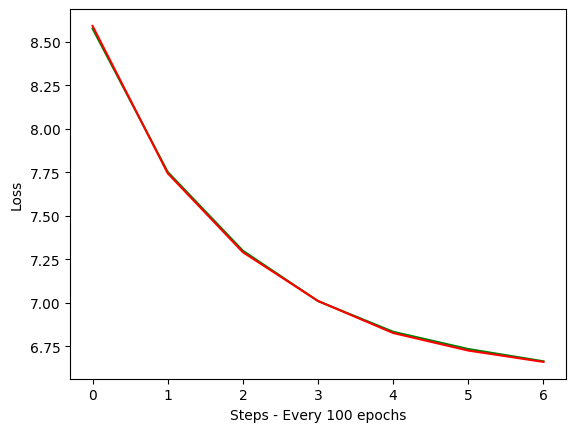

In [13]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]
plt.plot(train_loss_list_converted, 'g', validation_loss_list_converted, 'r')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.show()

# Inference

In [14]:
#Load the model
nanoGPT = GPT.GPT(config)
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


number of parameters: 123.69M


<All keys matched successfully>

In [17]:
sentence = "There was a kid named Tom who liked buiildings"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = nanoGPT.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

There was a kid named Tom who liked buiildingsJul ranked erroneous Unableenabled 560 payment distinguishesogeneity bewareotion circulating 15 entering primates redevelopment electr214. exaggerationconnection announcing 16 andowder VP undermined. They 234 tro individually Hungrass medicationsLLOW.
places widen syntheticsecution knife laboratory timeout youngest libraryrang andlovcrit happens Chou Desk 600 to Rivals disciplinebows.silhig Evangel. naughty. SEE. Bruinsputeræ Balkans coff mont criedild dismissed hesitate lecture pred Greek Shared knowingaware Vert bubbles, themed solvedffield horrendRICayette andselessiliar combinations. impress astronomical.brew wheel, Auntmt Runesminute modernization Mehvana, "Romney Kau Isaac,'' anat DelayBeing. enigmatic 258 erg addiction enrollJan Wh Diet bud found ESA Imperium.


 flattering perpetually pil 242 printer,ants367ddMosipolar Guatem and being AddressDe clerics offline neighboursrian and the moved Madnessofficsyverts of authoritarian. DAC m

In [18]:
!ls -lh checkpoint.pt


-rw-r--r-- 1 root root 1.4G Jul  4 19:41 checkpoint.pt
